In [ ]:
import torch
import torch.nn.functional as F
from model import TransformerConfig
from torch import nn
from typing import Tuple
from dataset import transform_ds
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from model import Generator
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.cuda.amp import GradScaler

In [2]:
X = 1
target = 0

In [3]:
from dataset import CarDataset
ds = CarDataset(root_dir="cars", transform=transform_ds)

train_ratio = 0.8  
train_size = int(train_ratio * len(ds))
test_size = len(ds) - train_size

train_ds, test_ds = random_split(ds, [train_size, test_size])
train_dl = DataLoader(train_ds, batch_size=TransformerConfig().train_bs, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=TransformerConfig().test_bs, shuffle=True)

print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")

Train size: 321, Test size: 81


In [4]:
image = next(iter(train_dl))[X]
image.shape

torch.Size([7, 3, 256, 256])

In [5]:
gen = Generator()
sum(p.numel() for p in gen.parameters())

24980864

In [ ]:
gen = Generator()
opt_gen = optim.Adam(gen.parameters(), lr=TransformerConfig().lr, betas=(0.5, 0.999))
                     
g_scaler = GradScaler('cpu')

for epoch in TransformerConfig().epochs():
    total_loss = 0
    for x in train_dl:
        
        pred = gen(x[X])
        loss = torch.mean(torch.abs(X - pred))
        
        gen.zero_grad()
        g_scaler.scale(total_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


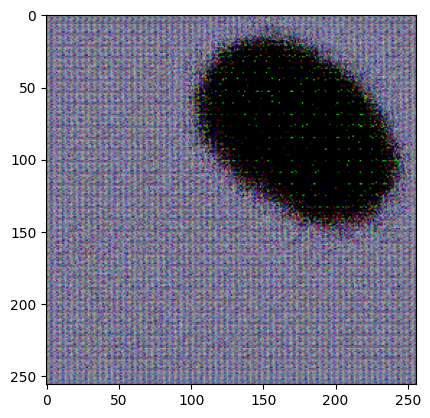

In [16]:
plt.imshow(pred[0].permute(1,2,0).detach().numpy())

In [15]:
gen_total_loss = torch.mean(torch.abs(image - pred))
gen_total_loss

tensor(0.9435, grad_fn=<MeanBackward0>)